# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib

# Load data
data = pd.read_csv('/content/asthma_disease_data.csv')
# Display the first few rows
data.head()


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,PhysicalActivity,DietQuality,SleepQuality,...,LungFunctionFEV1,LungFunctionFVC,Wheezing,ShortnessOfBreath,ChestTightness,Coughing,NighttimeSymptoms,ExerciseInduced,Diagnosis,DoctorInCharge
0,5034,63,0,1,0,15.848744,0,0.894448,5.488696,8.701003,...,1.369051,4.941206,0,0,1,0,0,1,0,Dr_Confid
1,5035,26,1,2,2,22.757042,0,5.897329,6.341014,5.153966,...,2.197767,1.702393,1,0,0,1,1,1,0,Dr_Confid
2,5036,57,0,2,1,18.395396,0,6.739367,9.196237,6.840647,...,1.698011,5.022553,1,1,1,0,1,1,0,Dr_Confid
3,5037,40,1,2,1,38.515278,0,1.404503,5.826532,4.253036,...,3.032037,2.300159,1,0,1,1,1,0,0,Dr_Confid
4,5038,61,0,0,3,19.283802,0,4.604493,3.127048,9.625799,...,3.470589,3.067944,1,1,1,0,0,1,0,Dr_Confid


In [ ]:
# Handle missing values
data = data.dropna()

# Encode categorical variables
label_encoder = LabelEncoder()
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Ethnicity'] = label_encoder.fit_transform(data['Ethnicity'])
data['EducationLevel'] = label_encoder.fit_transform(data['EducationLevel'])

# Split data into features and target
X = data.drop(['PatientID', 'Diagnosis', 'DoctorInCharge'], axis=1)
y = data['Diagnosis']

# Normalize/standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Initial Random Forest to determine feature importance
initial_model = RandomForestClassifier(n_estimators=100, random_state=42)
initial_model.fit(X_scaled, y)

# Get feature importances
feature_importances = initial_model.feature_importances_

# Select top features based on importance
top_features = np.argsort(feature_importances)[-10:]
print("Top 10 Features:")
print(X.columns[top_features])
X_top = X.iloc[:, top_features]
print(X_top)

# Normalize the selected features
X_top_scaled = scaler.fit_transform(X_top)


Top 10 Features:
Index(['Age', 'BMI', 'LungFunctionFVC', 'LungFunctionFEV1', 'PollenExposure',
       'SleepQuality', 'PollutionExposure', 'DietQuality', 'DustExposure',
       'PhysicalActivity'],
      dtype='object')
      Age        BMI  LungFunctionFVC  LungFunctionFEV1  PollenExposure  \
0      63  15.848744         4.941206          1.369051        2.855578   
1      26  22.757042         1.702393          2.197767        7.457665   
2      57  18.395396         5.022553          1.698011        1.448189   
3      40  38.515278         2.300159          3.032037        7.571845   
4      61  19.283802         3.067944          3.470589        3.049807   
...   ...        ...              ...               ...             ...   
2387   43  29.059613         5.166032          3.125249        7.314582   
2388   18  20.740850         5.509502          1.132977        2.279073   
2389   54  37.079560         3.346877          1.685962        3.055139   
2390   46  23.444712         1

In [ ]:
# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top_scaled, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
results = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    f1 = f1_score(y_test, y_pred, zero_division=1)

    results[model_name] = {
        'Model': model,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

# Display the results
for model_name, metrics in results.items():
    print(f"{model_name}:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision: {metrics['Precision']}")
    print(f"Recall: {metrics['Recall']}")
    print(f"F1-score: {metrics['F1-score']}")
    print("-" * 30)


Logistic Regression:
Accuracy: 0.5583700440528634
Precision: 0.5294117647058824
Recall: 0.5874125874125874
F1-score: 0.5569060773480663
------------------------------
Decision Tree:
Accuracy: 0.8447136563876652
Precision: 0.8025210084033614
Recall: 0.8904428904428905
F1-score: 0.8441988950276244
------------------------------
Random Forest:
Accuracy: 0.947136563876652
Precision: 0.9168490153172867
Recall: 0.9766899766899767
F1-score: 0.945823927765237
------------------------------
Gradient Boosting:
Accuracy: 0.8006607929515418
Precision: 0.7357414448669202
Recall: 0.9020979020979021
F1-score: 0.8104712041884817
------------------------------


In [ ]:
# Select the best model based on F1-score
best_model_name = max(results, key=lambda name: results[name]['F1-score'])
best_model = results[best_model_name]['Model']

# Save the best model and scaler
joblib.dump(best_model, 'best_asthma_detection_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print(f"The best model is: {best_model_name}")
print("The best model and scaler have been saved.")


The best model is: Random Forest
The best model and scaler have been saved.


# EDA

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# Load data
data = pd.read_csv('/content/asthma_disease_data.csv')


In [ ]:
# Display the first few rows
print(data.head())

# Display summary statistics
print(data.describe())

# Display data types and missing values
print(data.info())


   PatientID  Age  Gender  Ethnicity  EducationLevel        BMI  Smoking  \
0       5034   63       0          1               0  15.848744        0   
1       5035   26       1          2               2  22.757042        0   
2       5036   57       0          2               1  18.395396        0   
3       5037   40       1          2               1  38.515278        0   
4       5038   61       0          0               3  19.283802        0   

   PhysicalActivity  DietQuality  SleepQuality  ...  LungFunctionFEV1  \
0          0.894448     5.488696      8.701003  ...          1.369051   
1          5.897329     6.341014      5.153966  ...          2.197767   
2          6.739367     9.196237      6.840647  ...          1.698011   
3          1.404503     5.826532      4.253036  ...          3.032037   
4          4.604493     3.127048      9.625799  ...          3.470589   

   LungFunctionFVC  Wheezing  ShortnessOfBreath  ChestTightness  Coughing  \
0         4.941206         

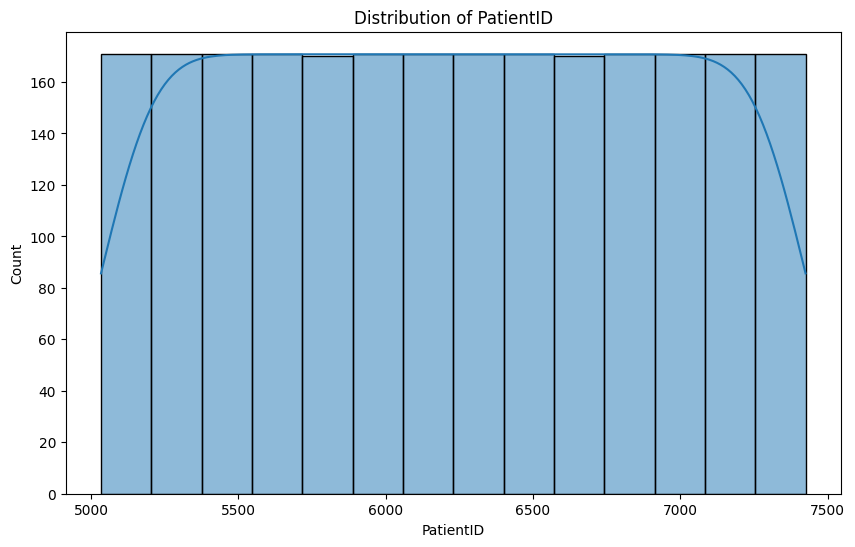

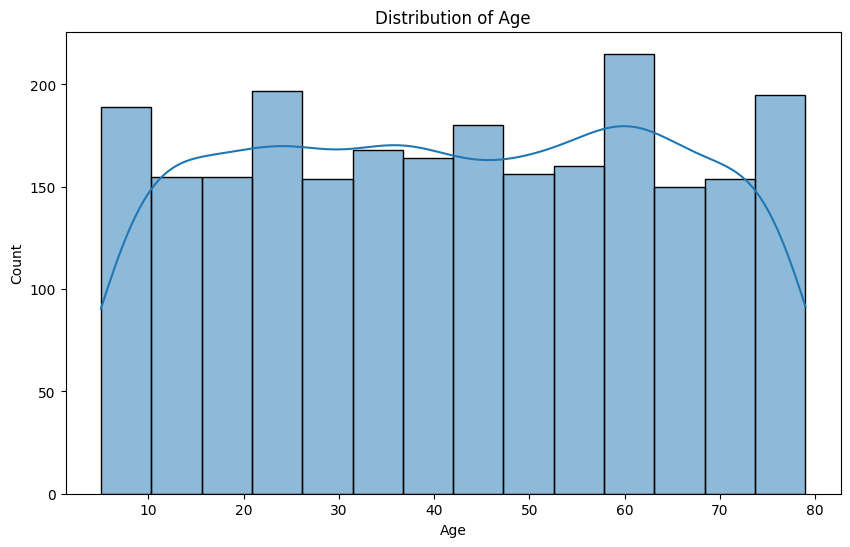

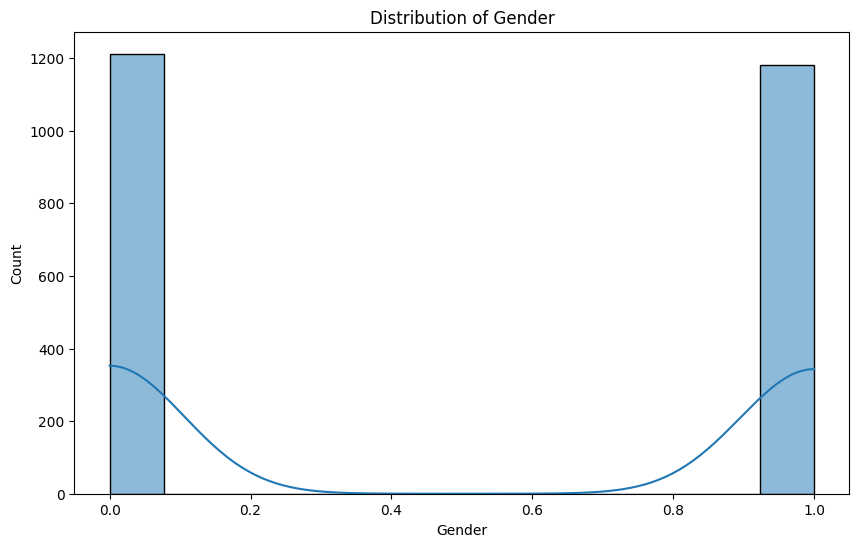

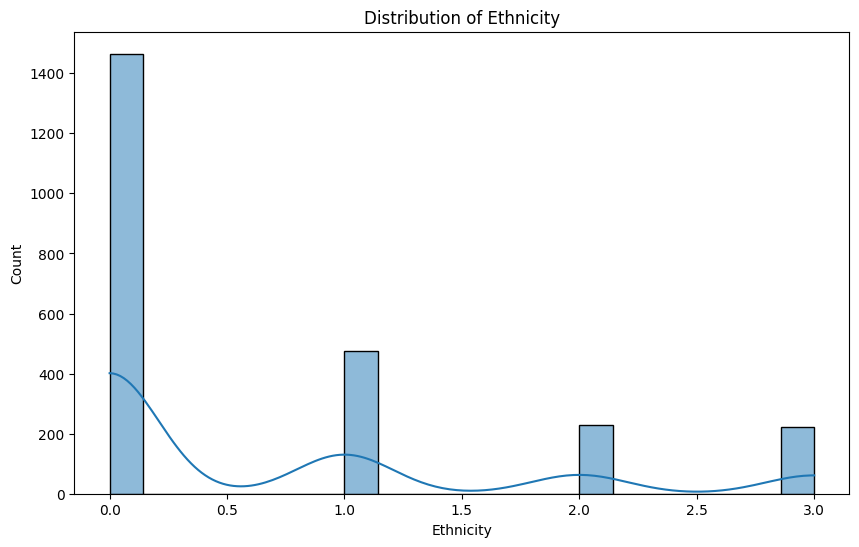

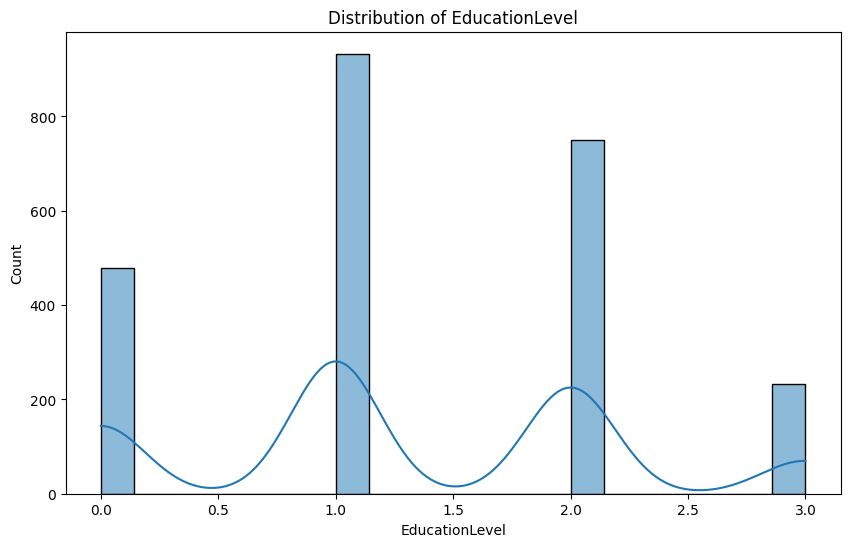

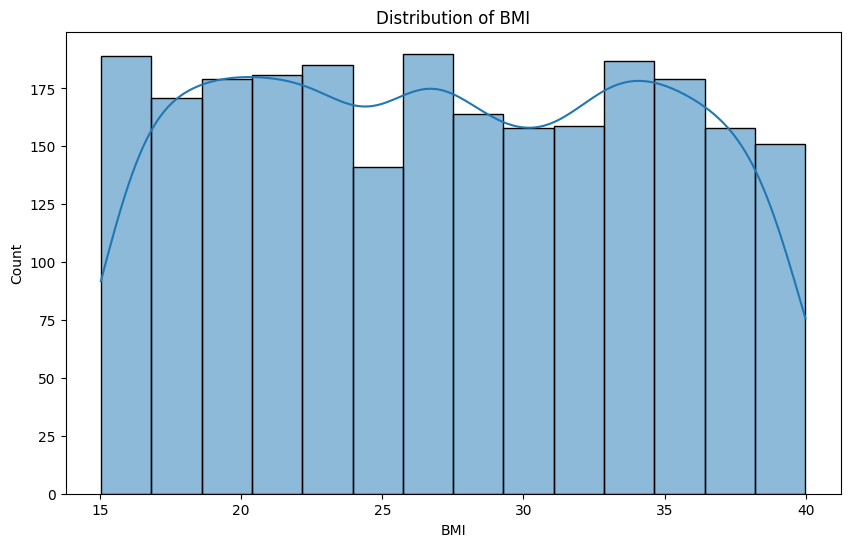

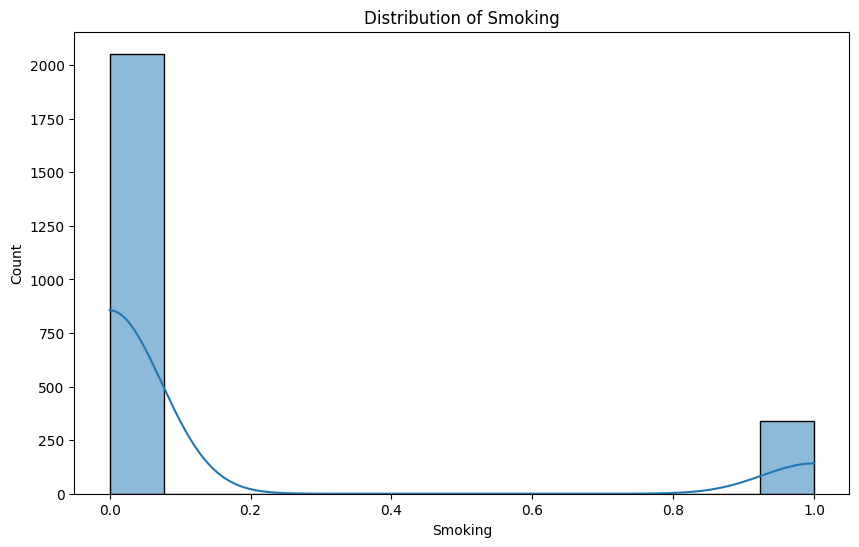

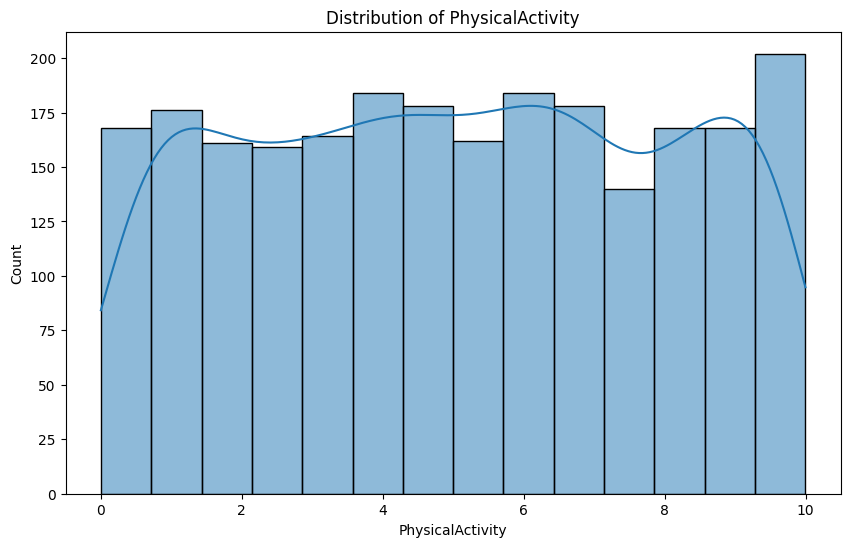

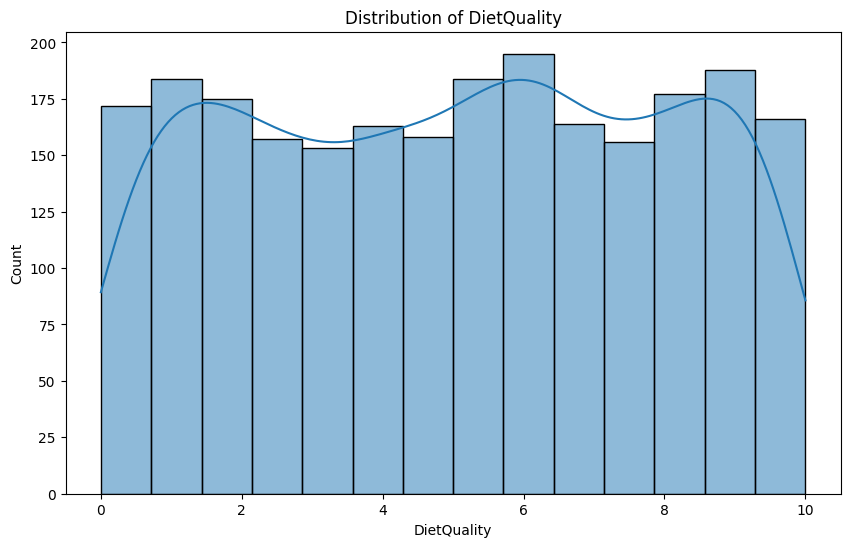

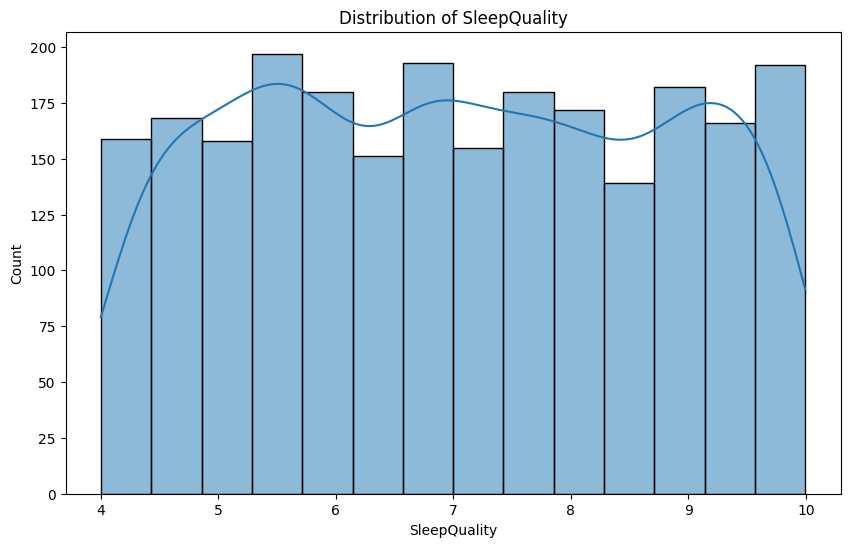

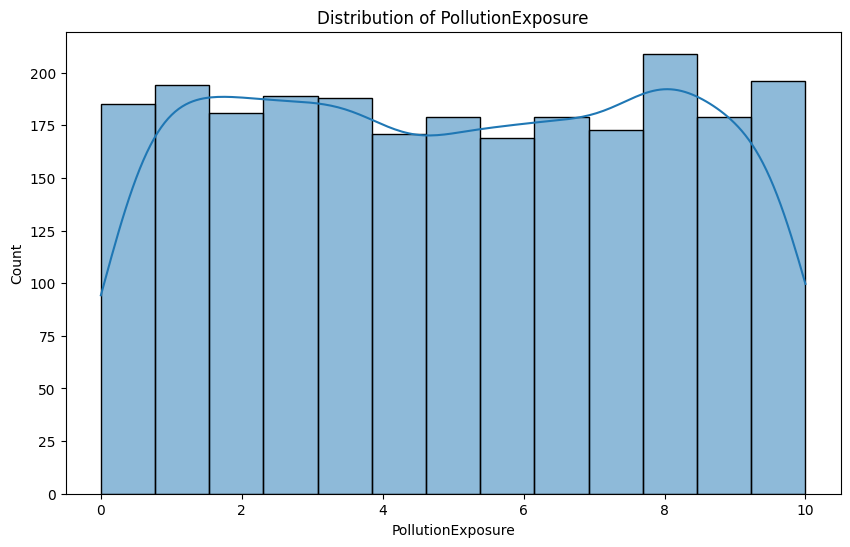

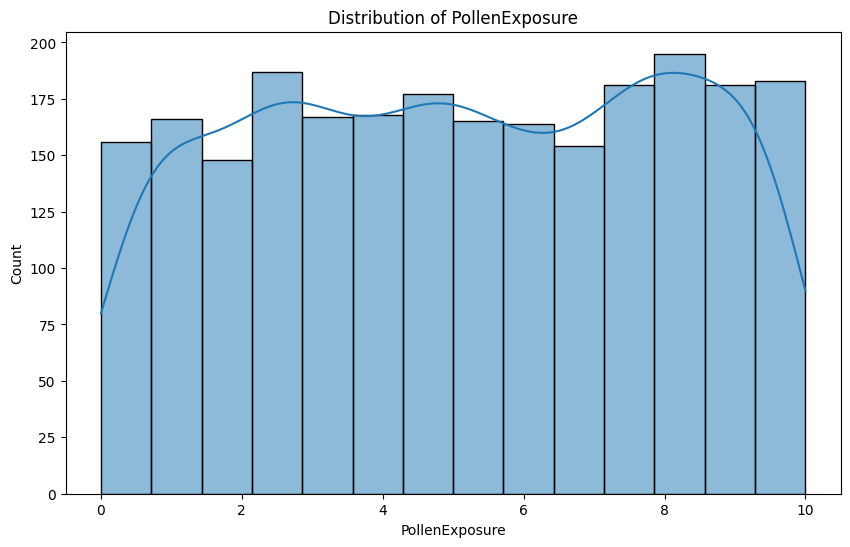

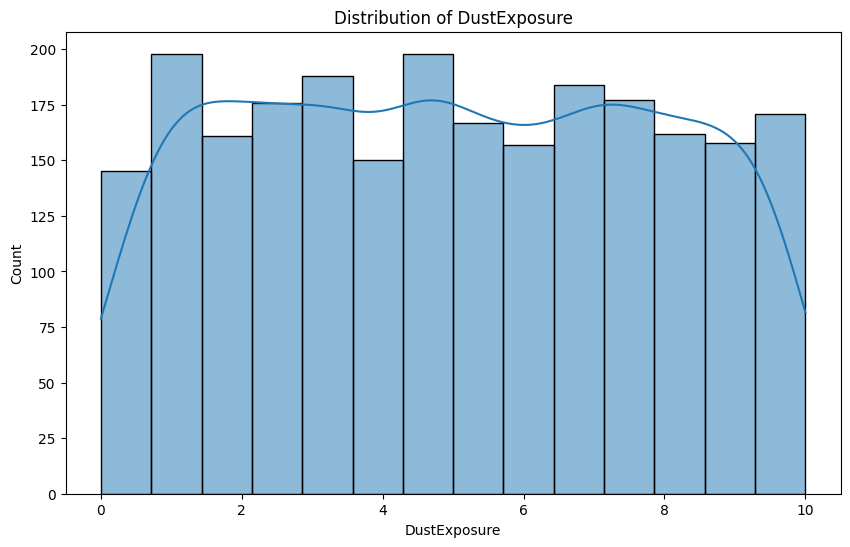

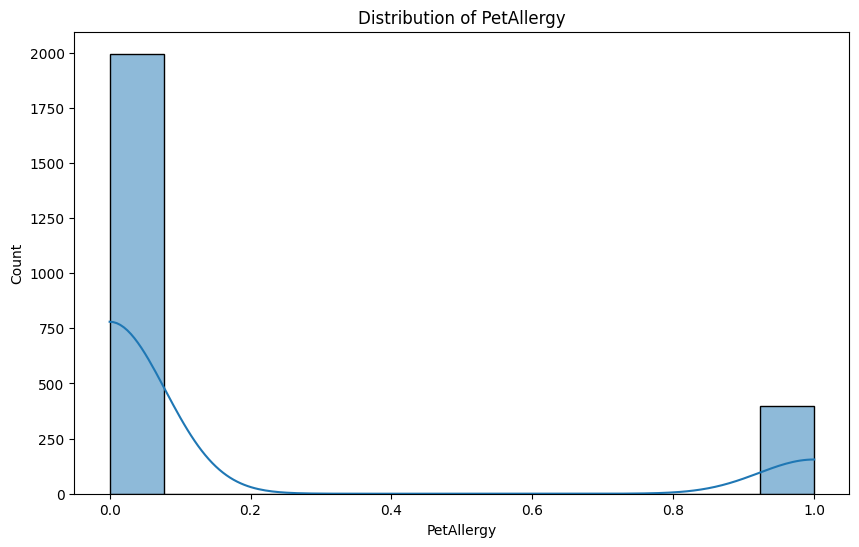

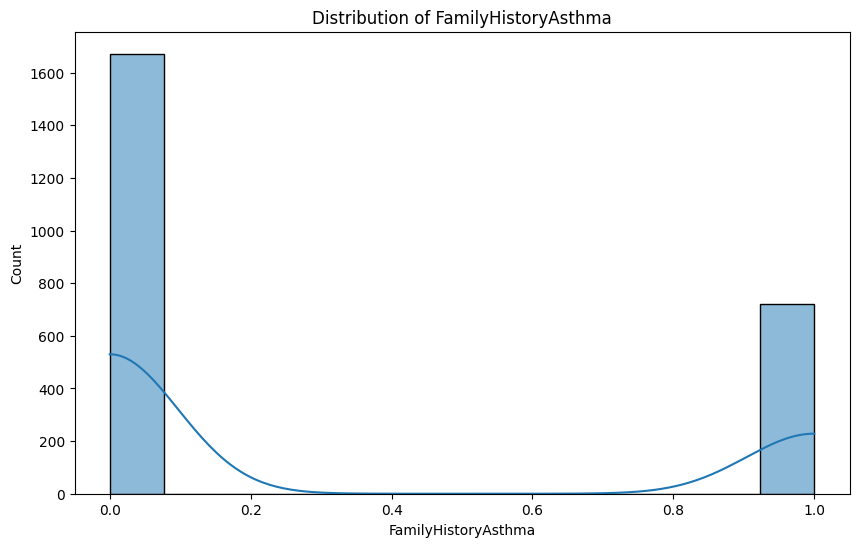

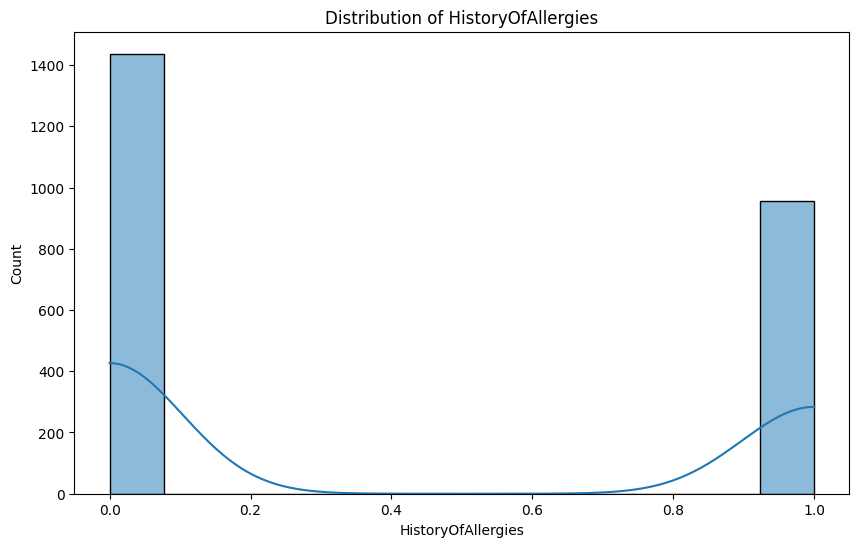

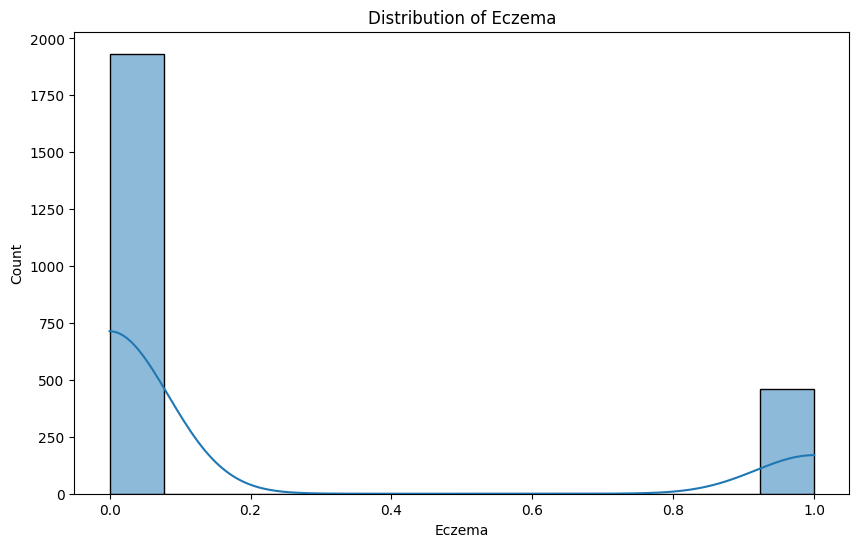

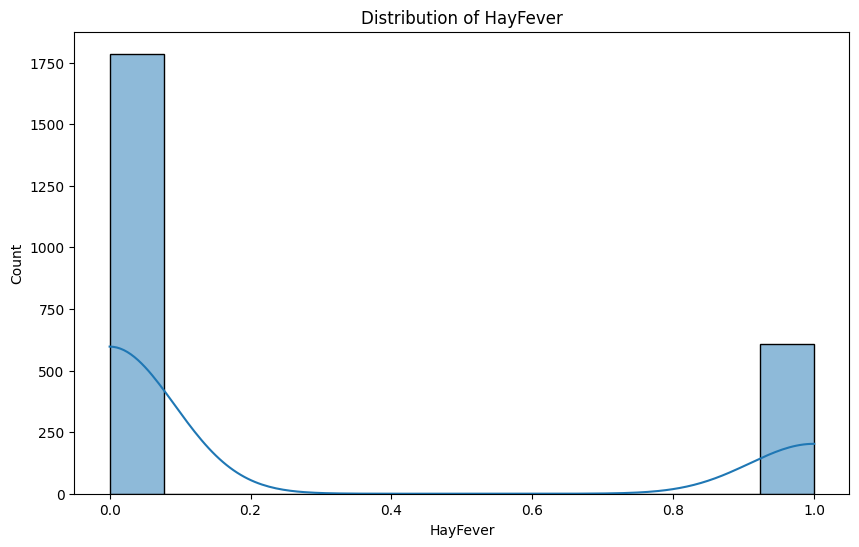

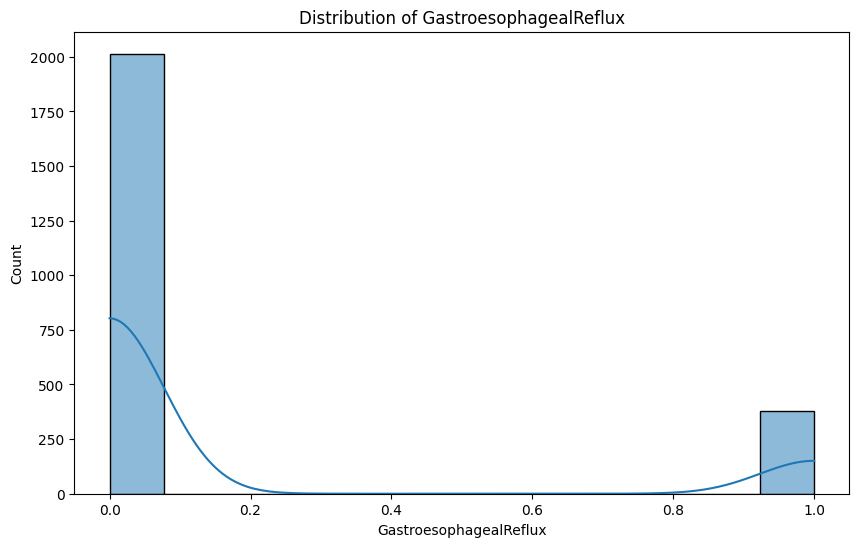

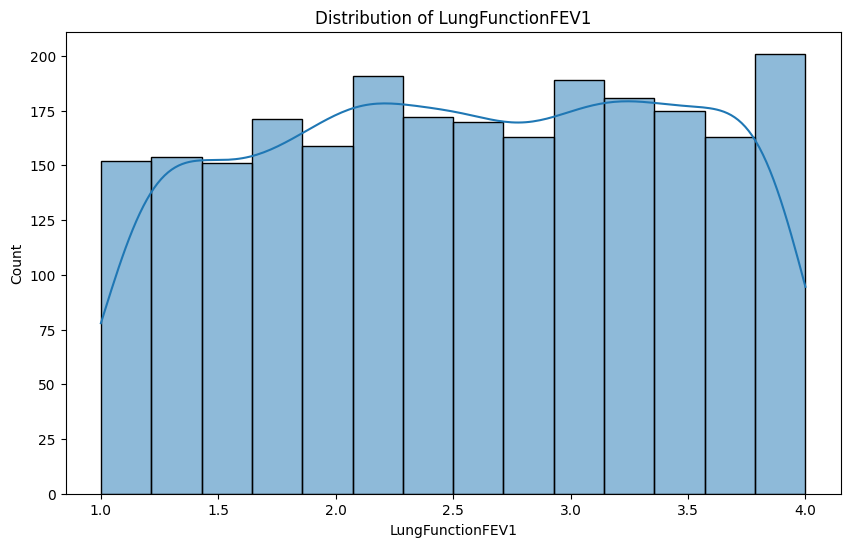

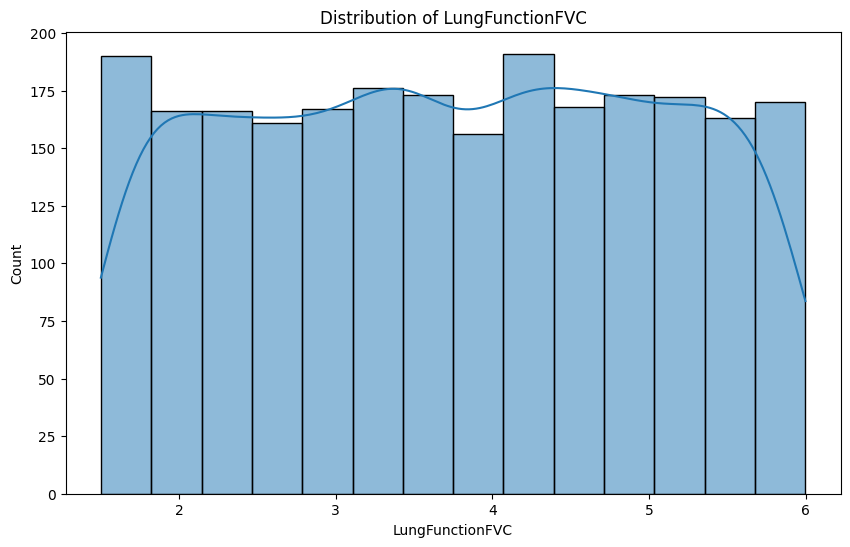

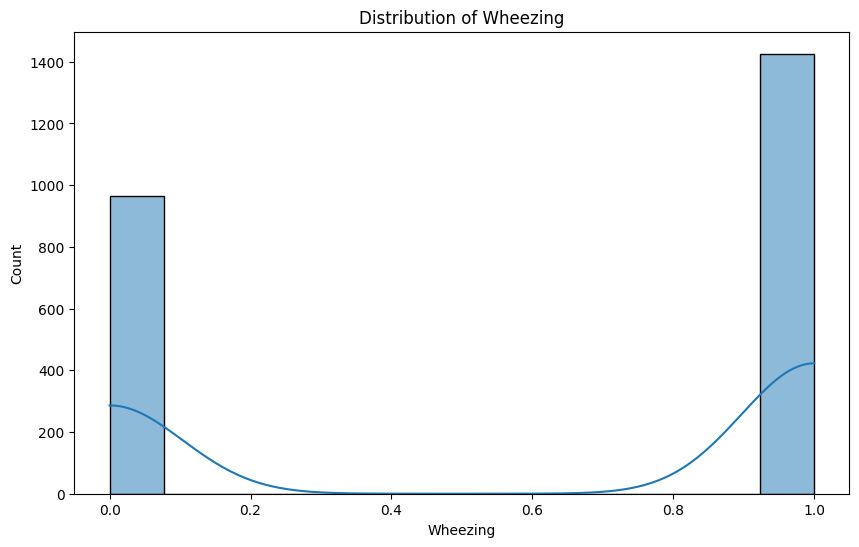

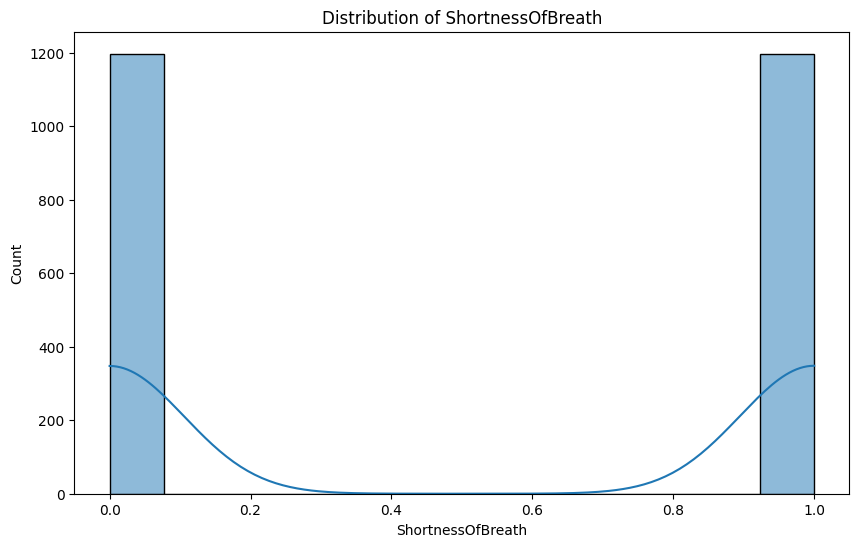

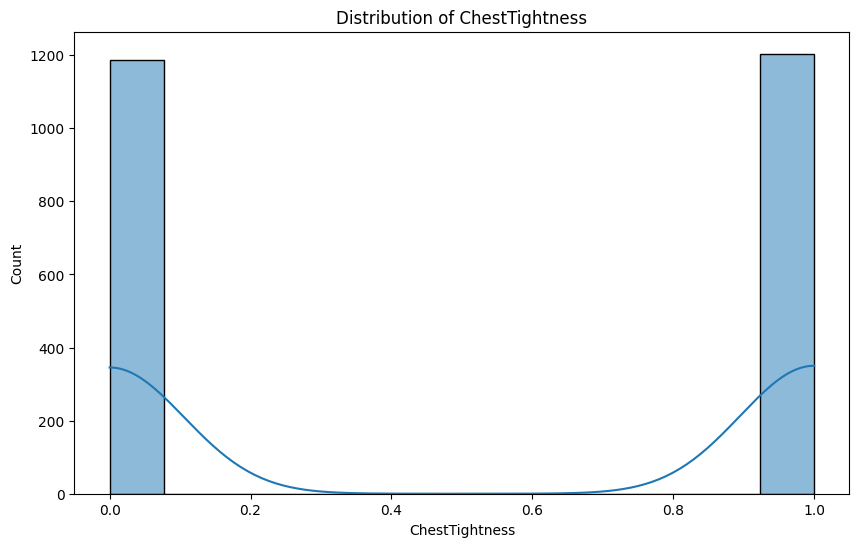

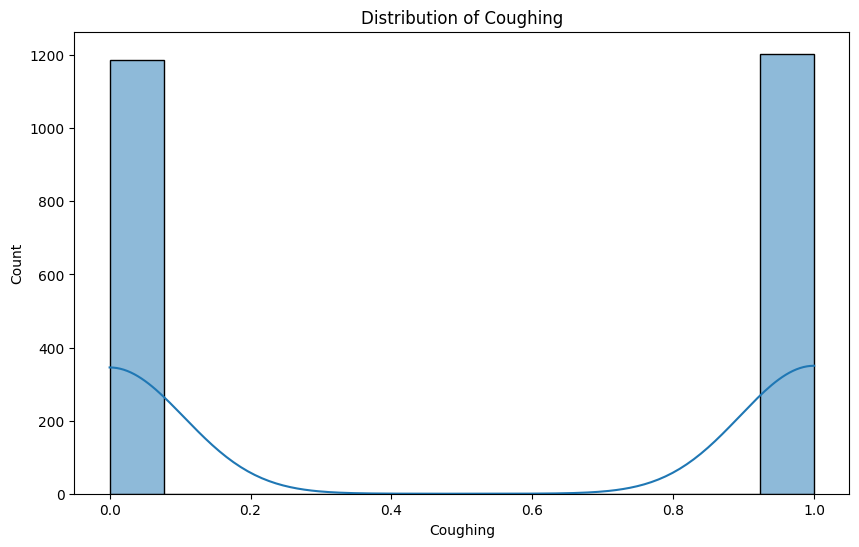

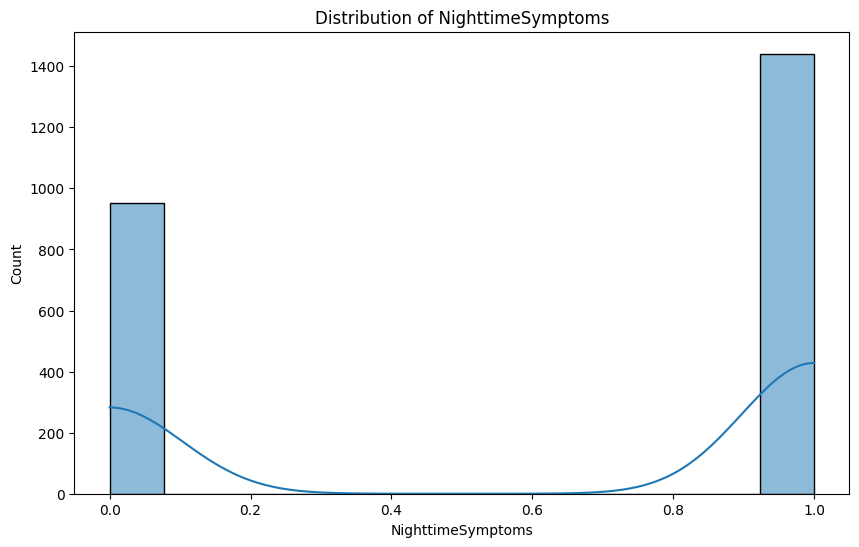

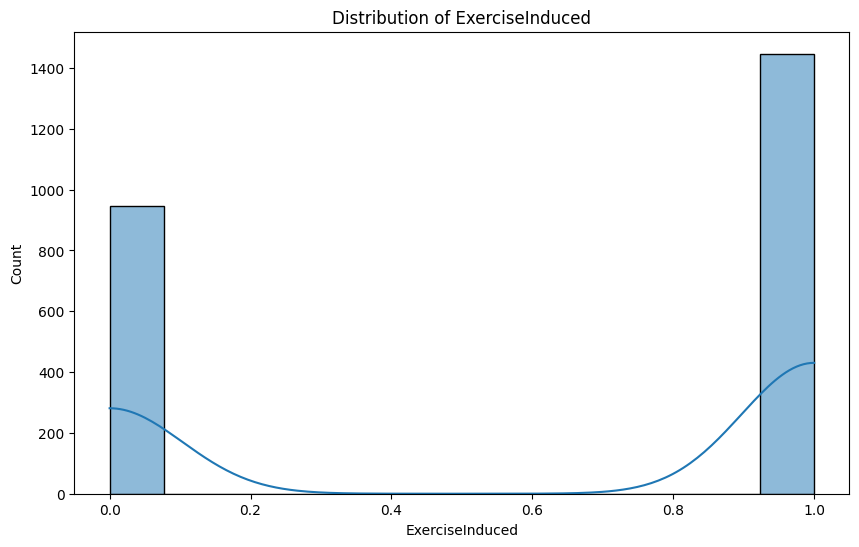

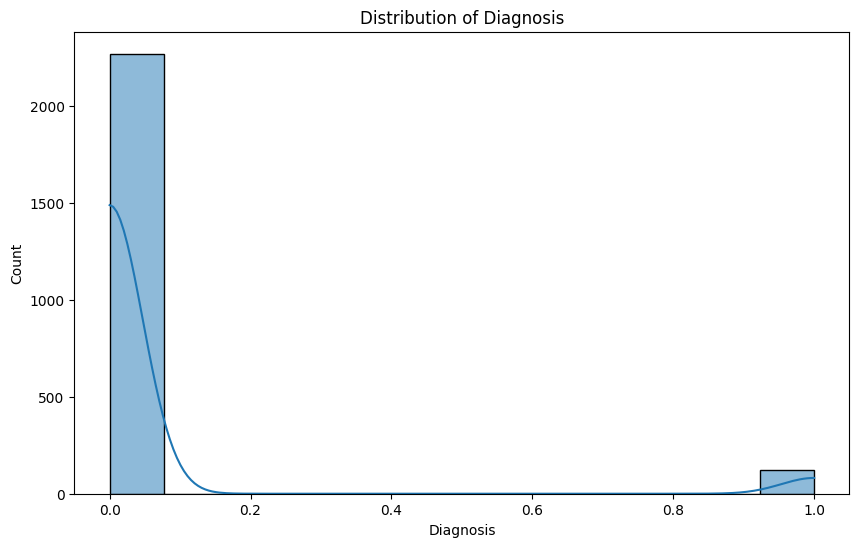

In [ ]:
# Distribution plots for numerical features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.savefig(f'{feature}_distribution.png')
    plt.show()


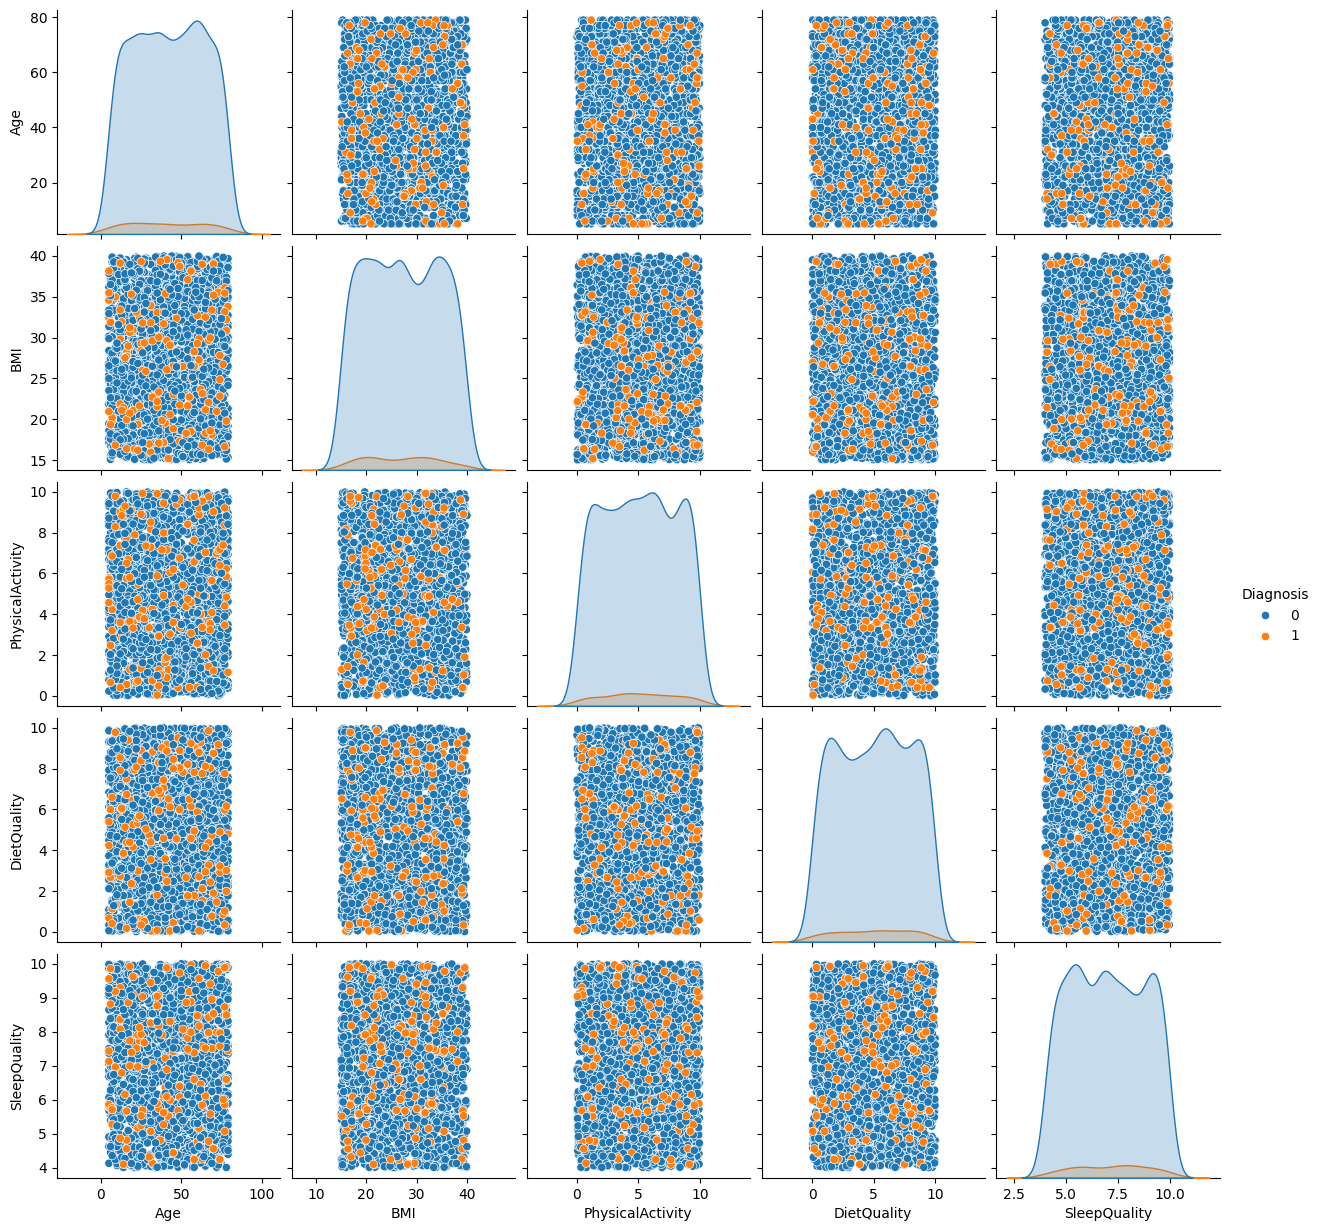

In [ ]:
# Pair plot for selected features
selected_features = ['Age', 'BMI', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'Diagnosis']

sns.pairplot(data[selected_features], hue='Diagnosis')
plt.savefig('pairplot_top_features.png')
plt.show()


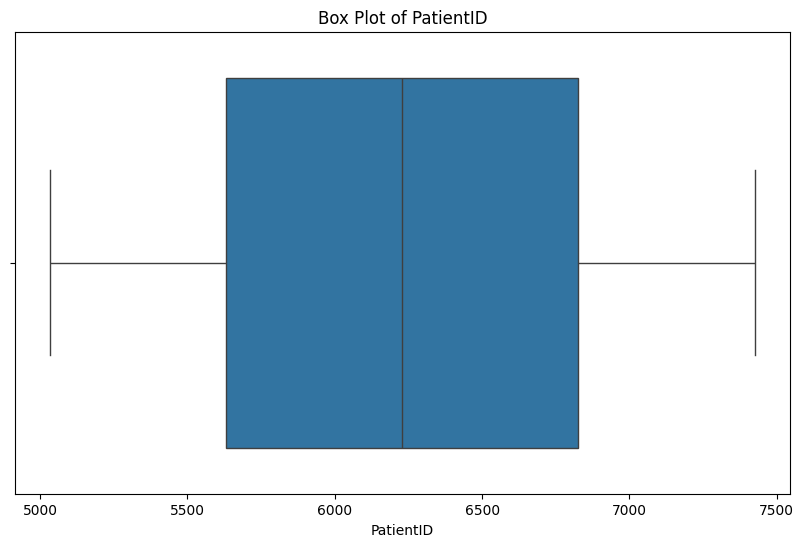

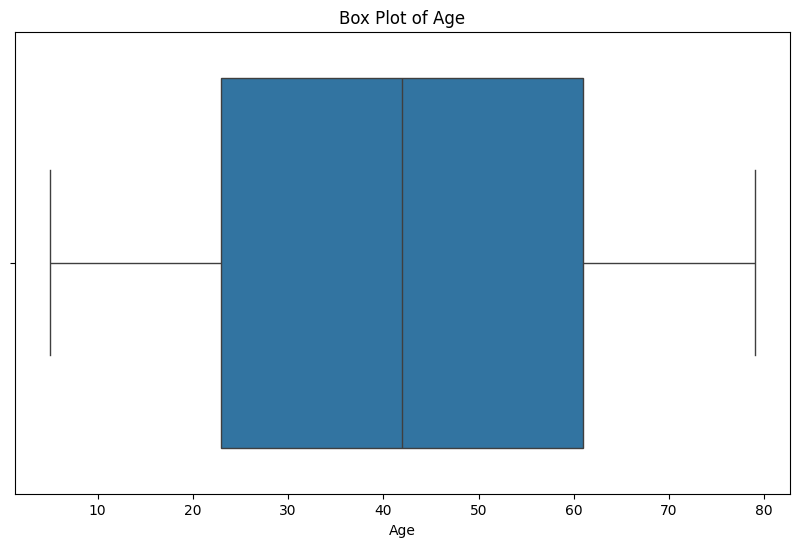

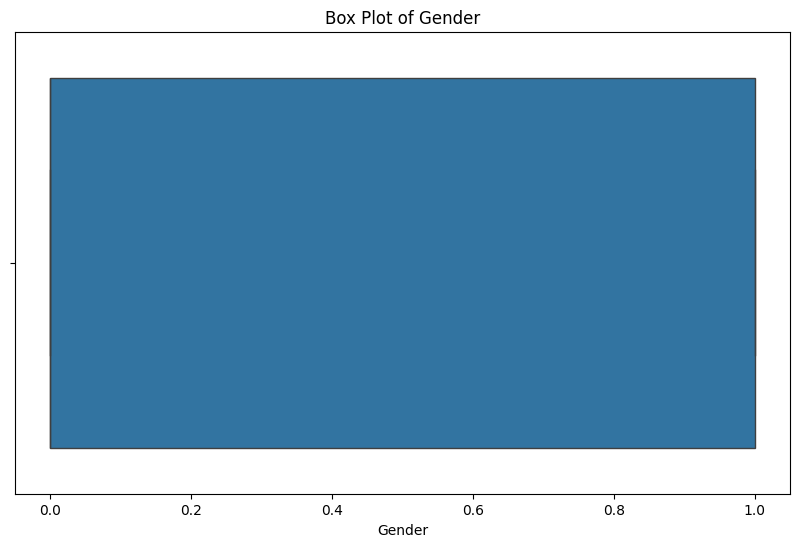

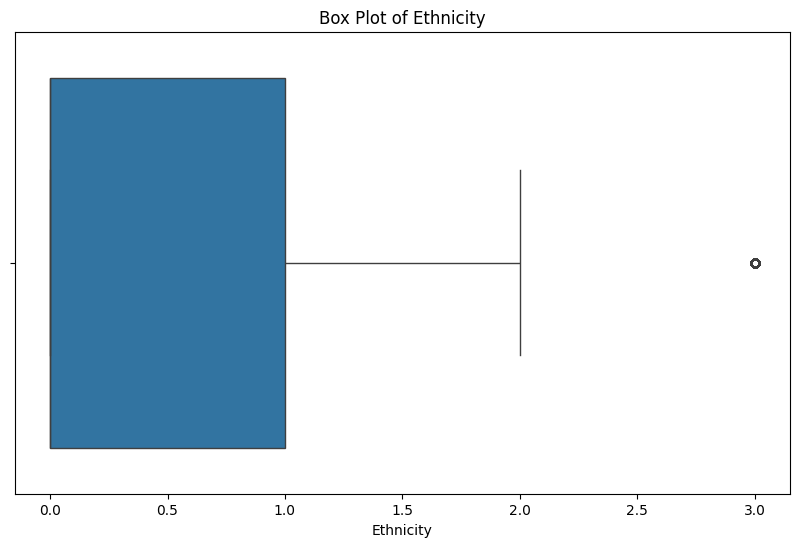

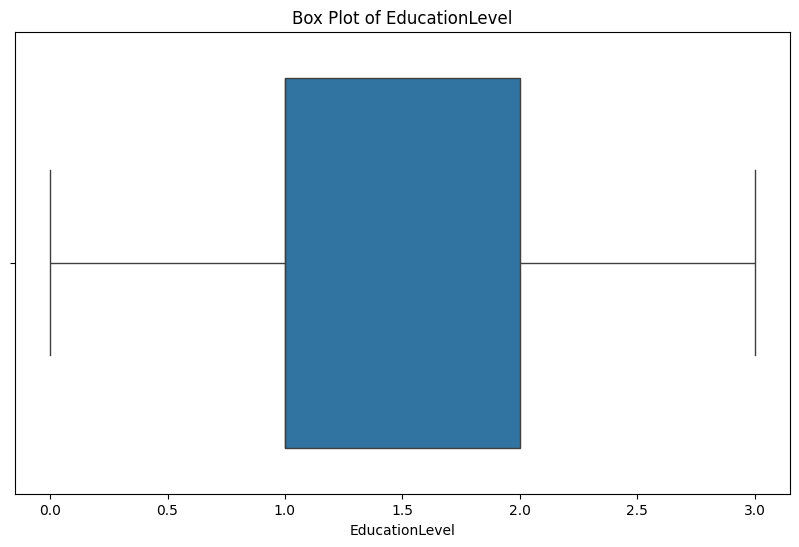

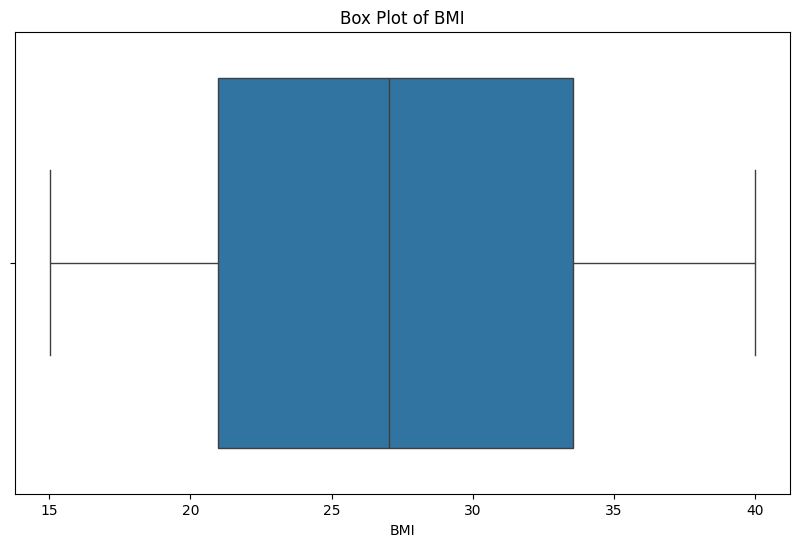

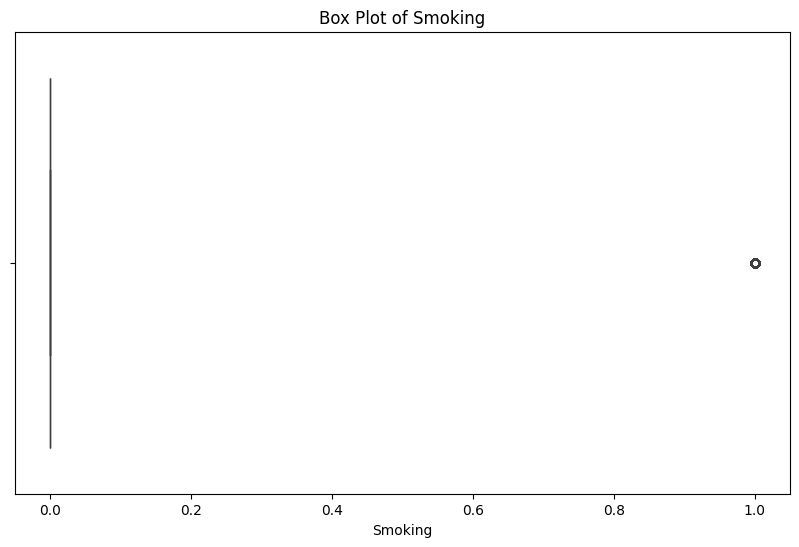

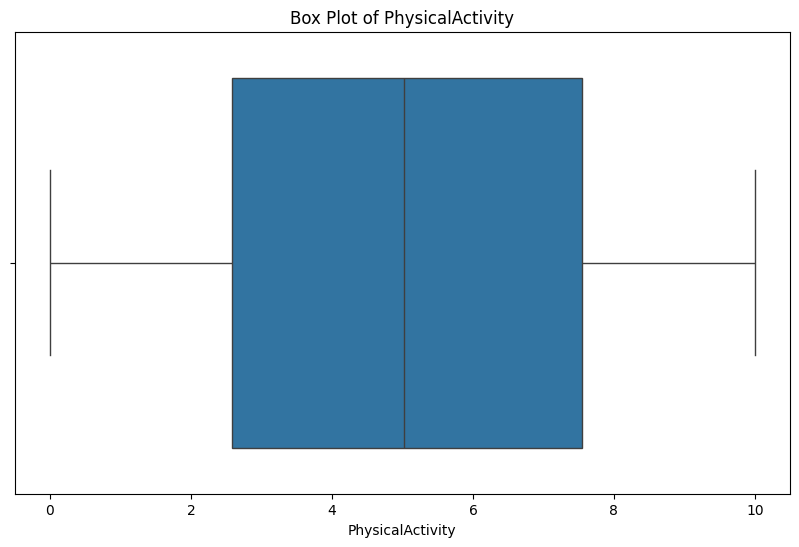

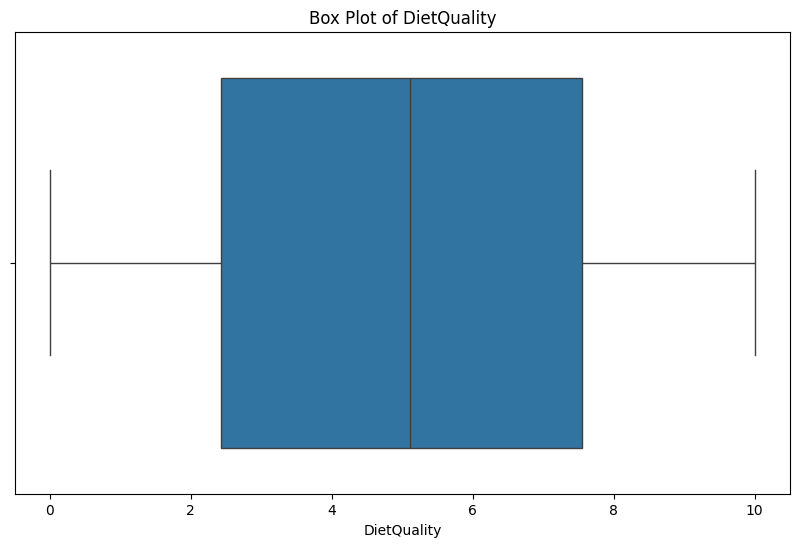

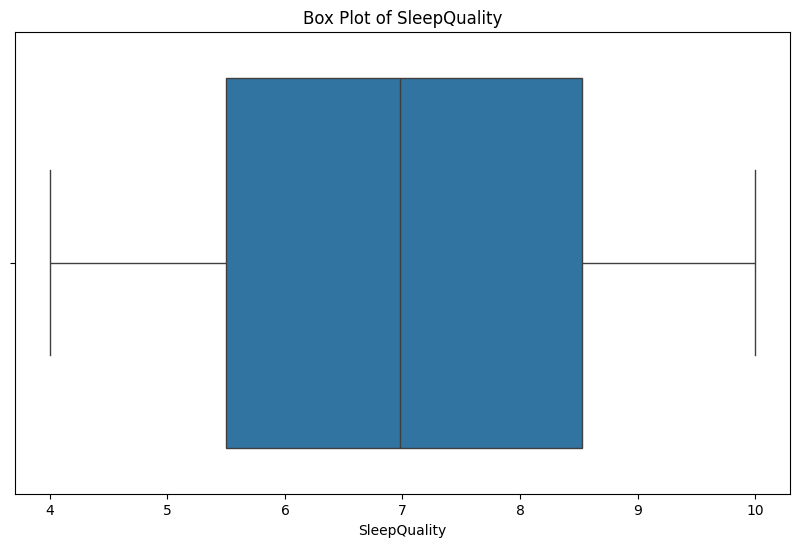

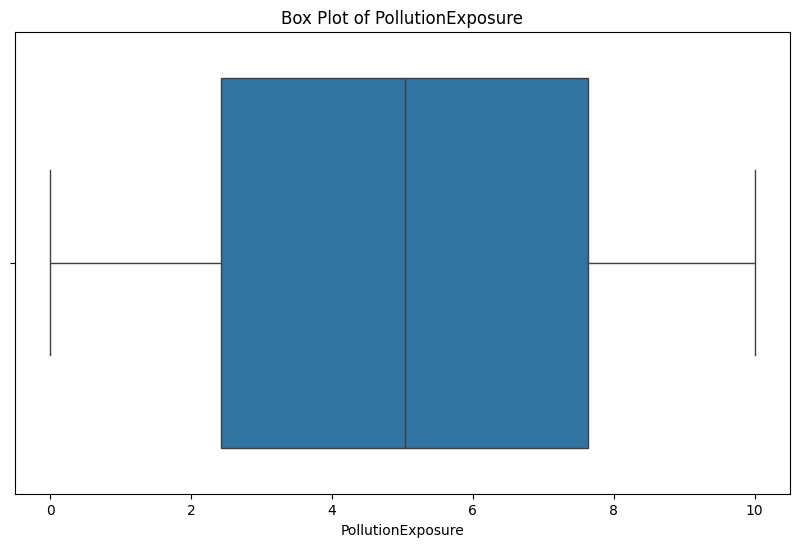

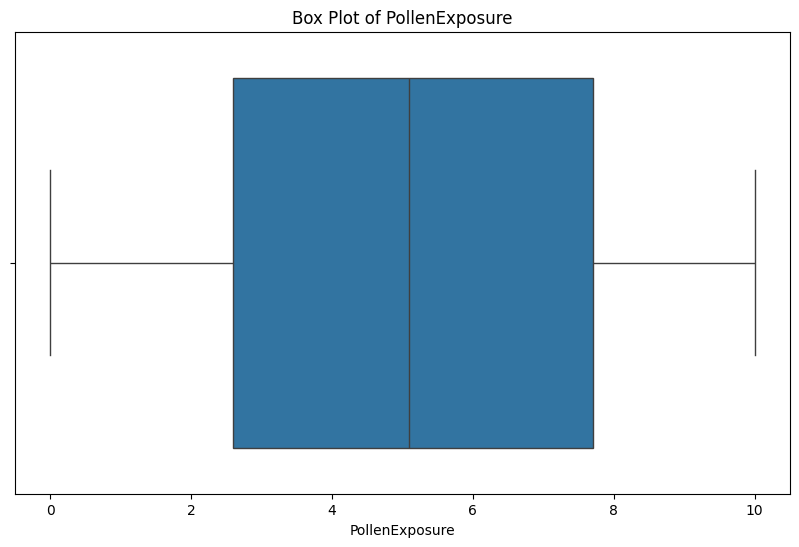

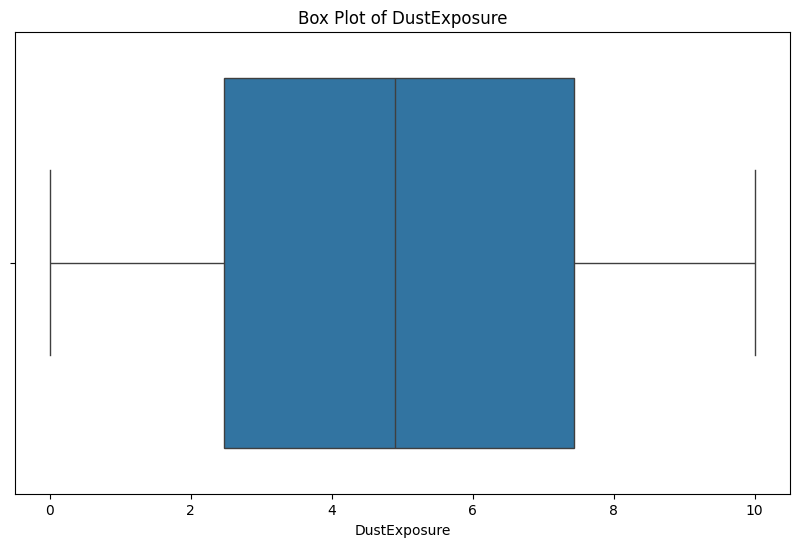

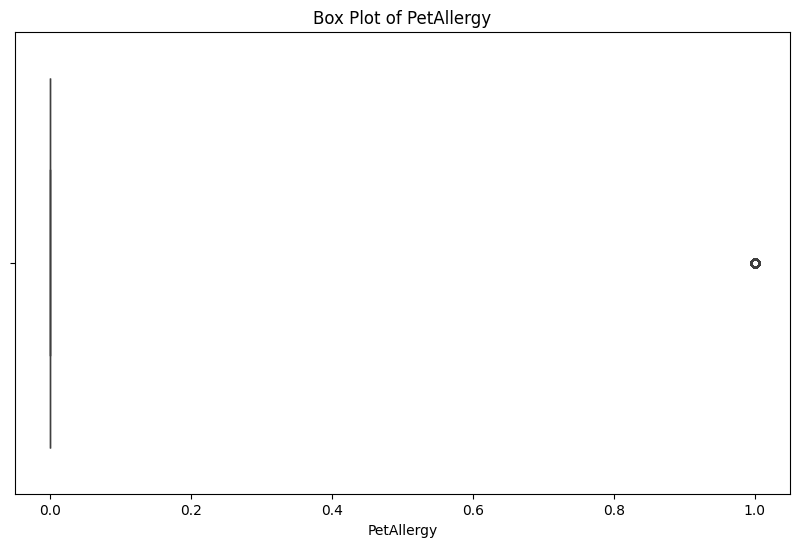

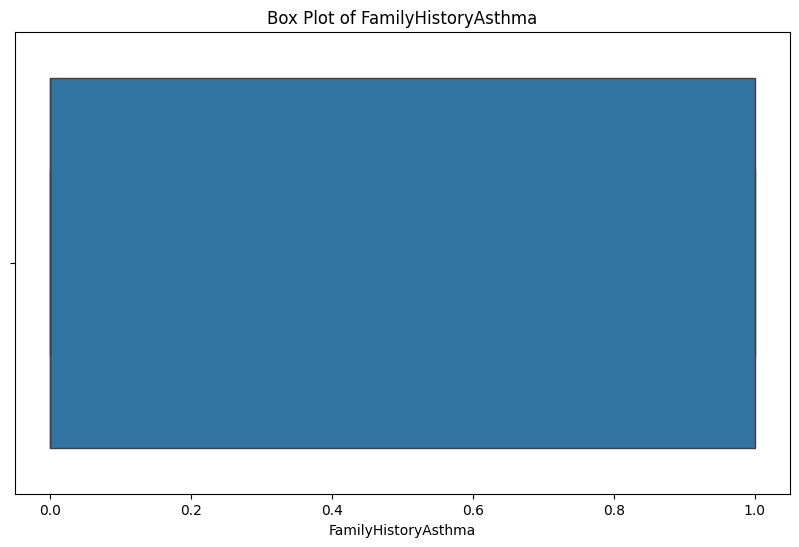

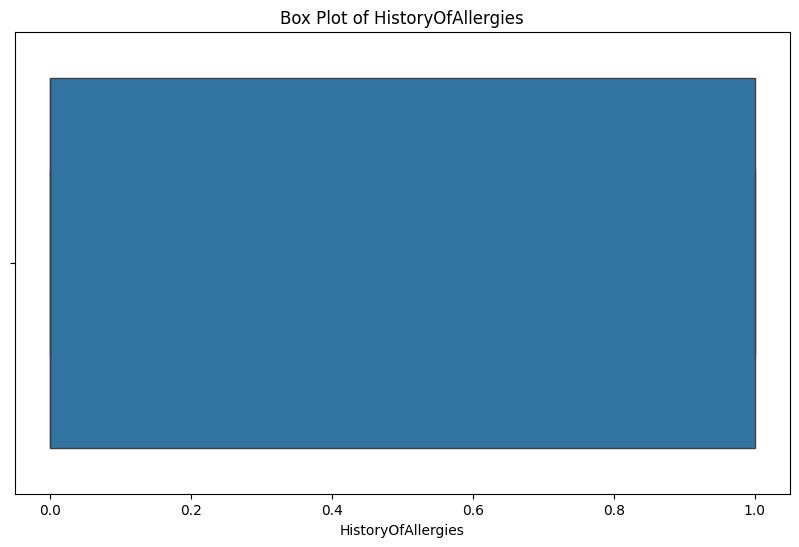

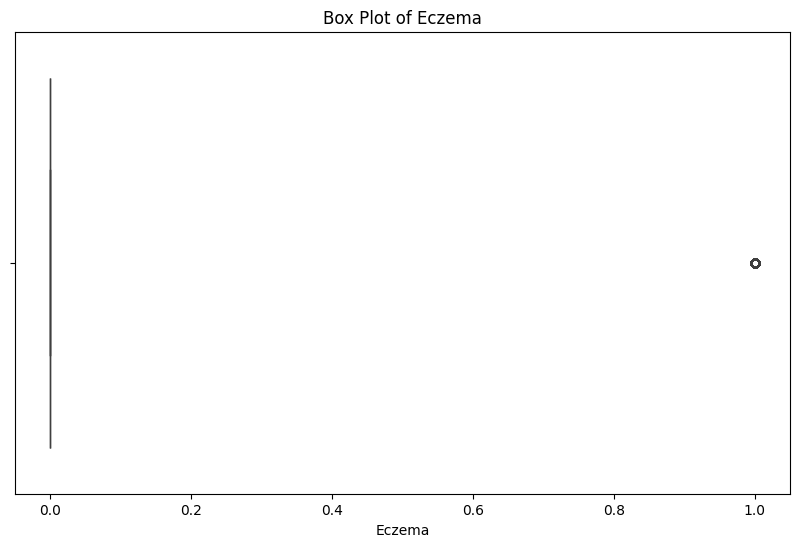

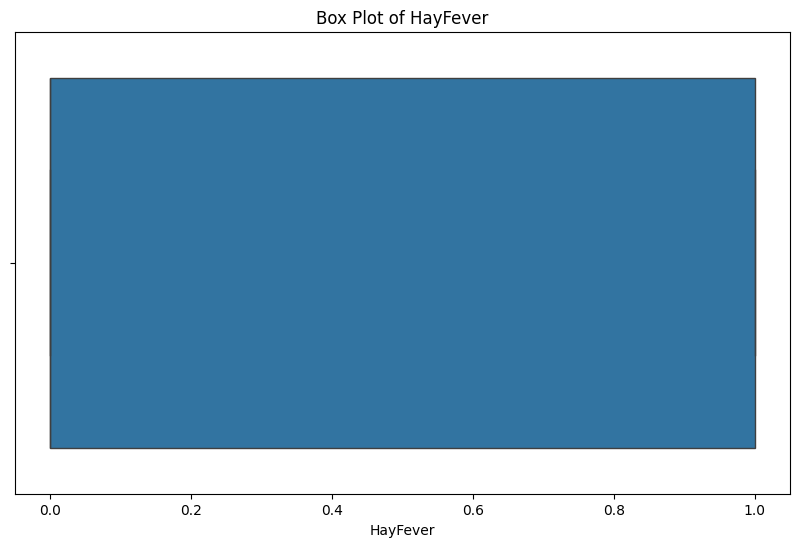

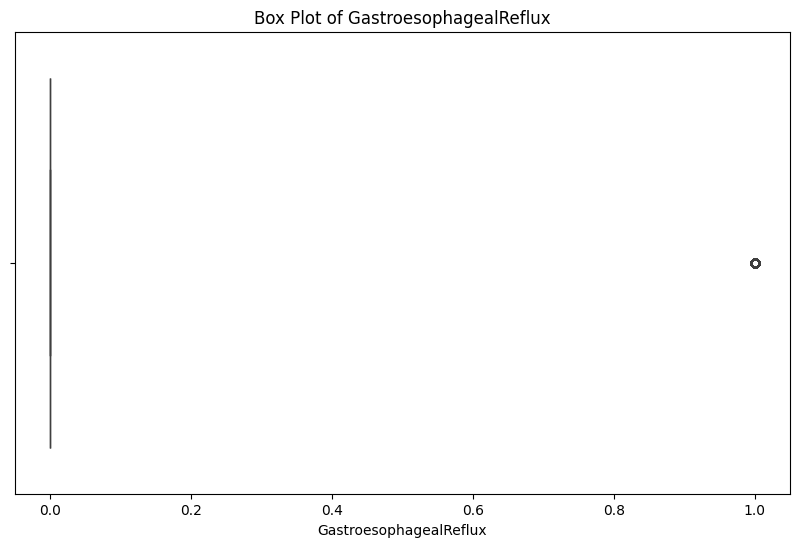

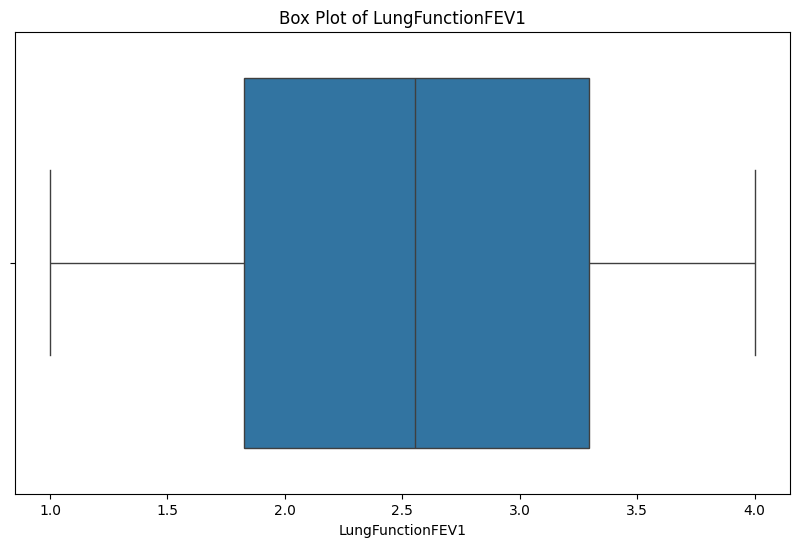

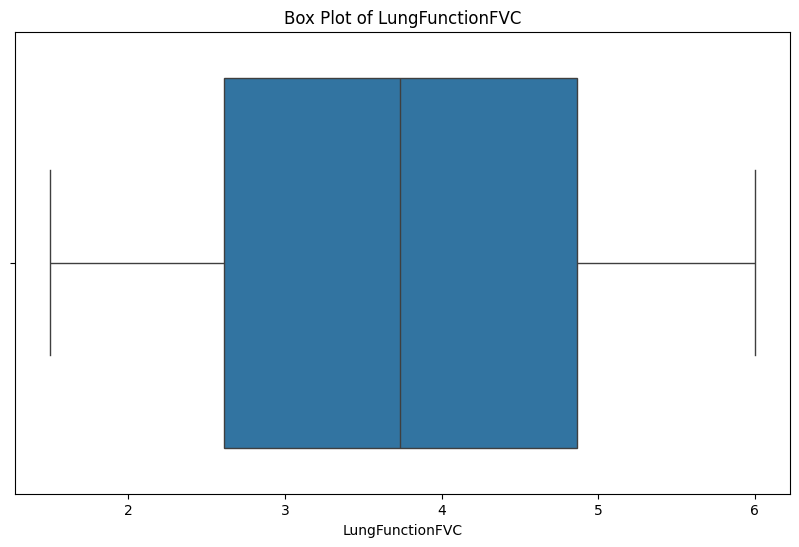

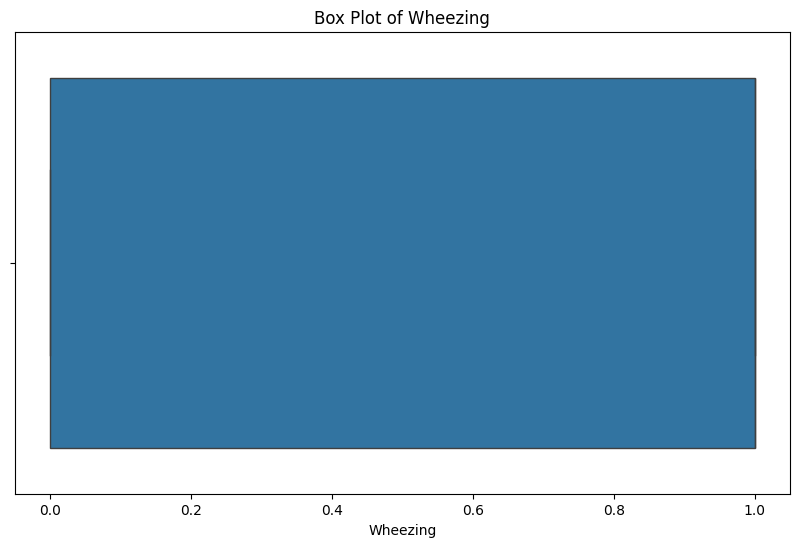

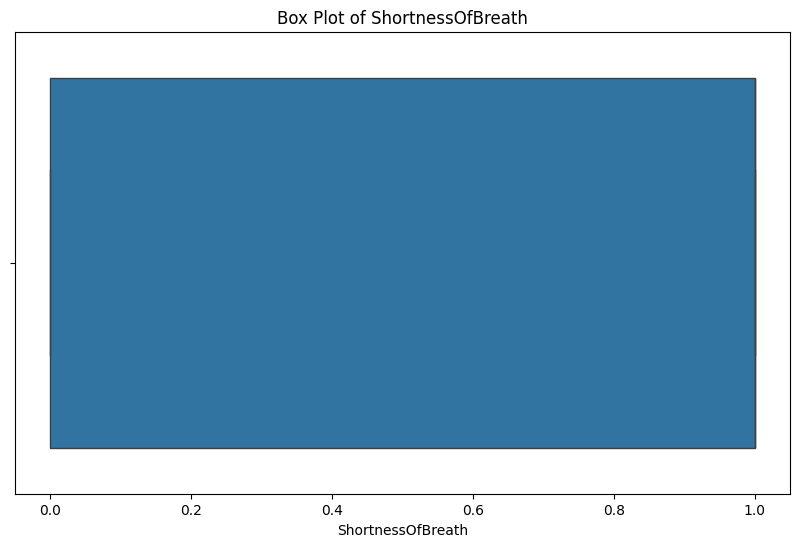

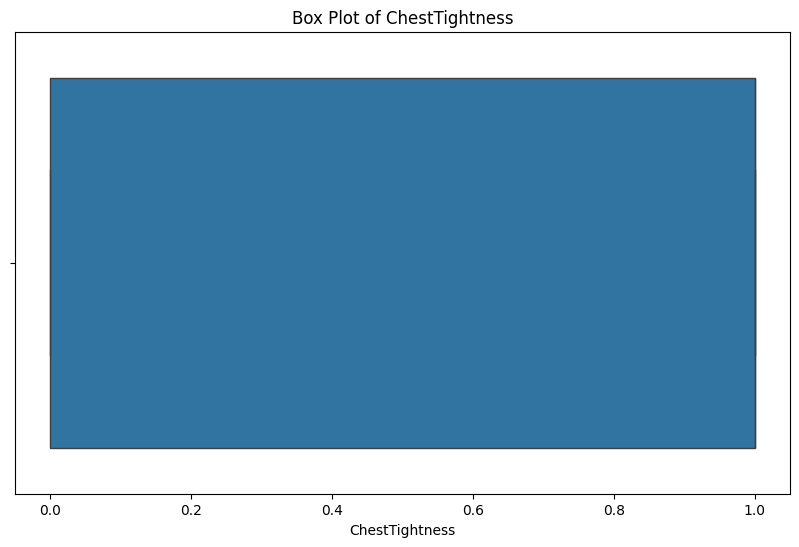

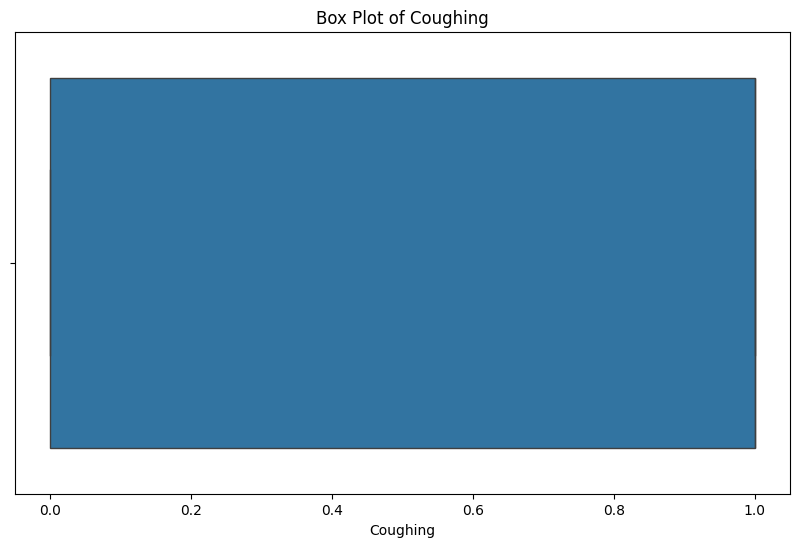

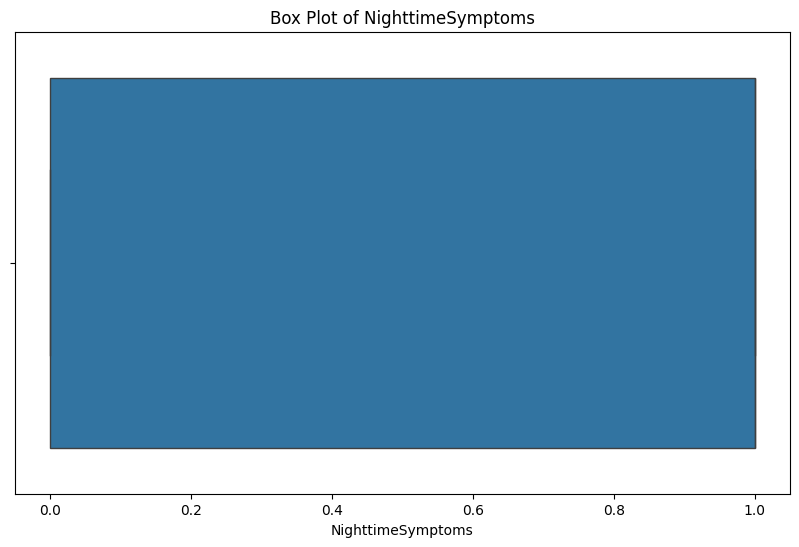

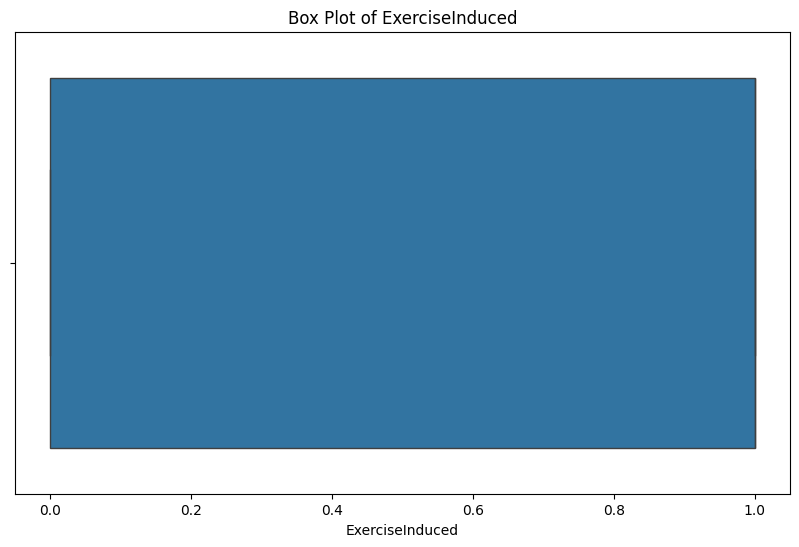

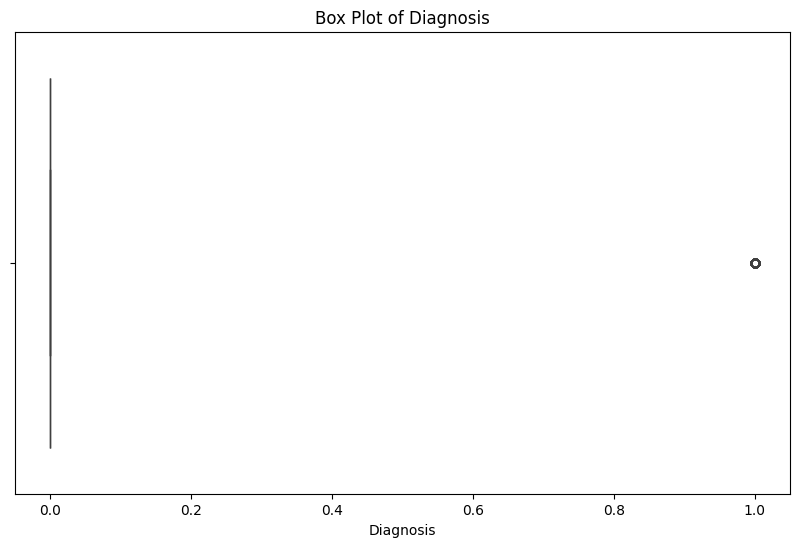

In [ ]:
# Box plots to detect outliers
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=data[feature])
    plt.title(f'Box Plot of {feature}')
    plt.savefig(f'{feature}_boxplot.png')
    plt.show()


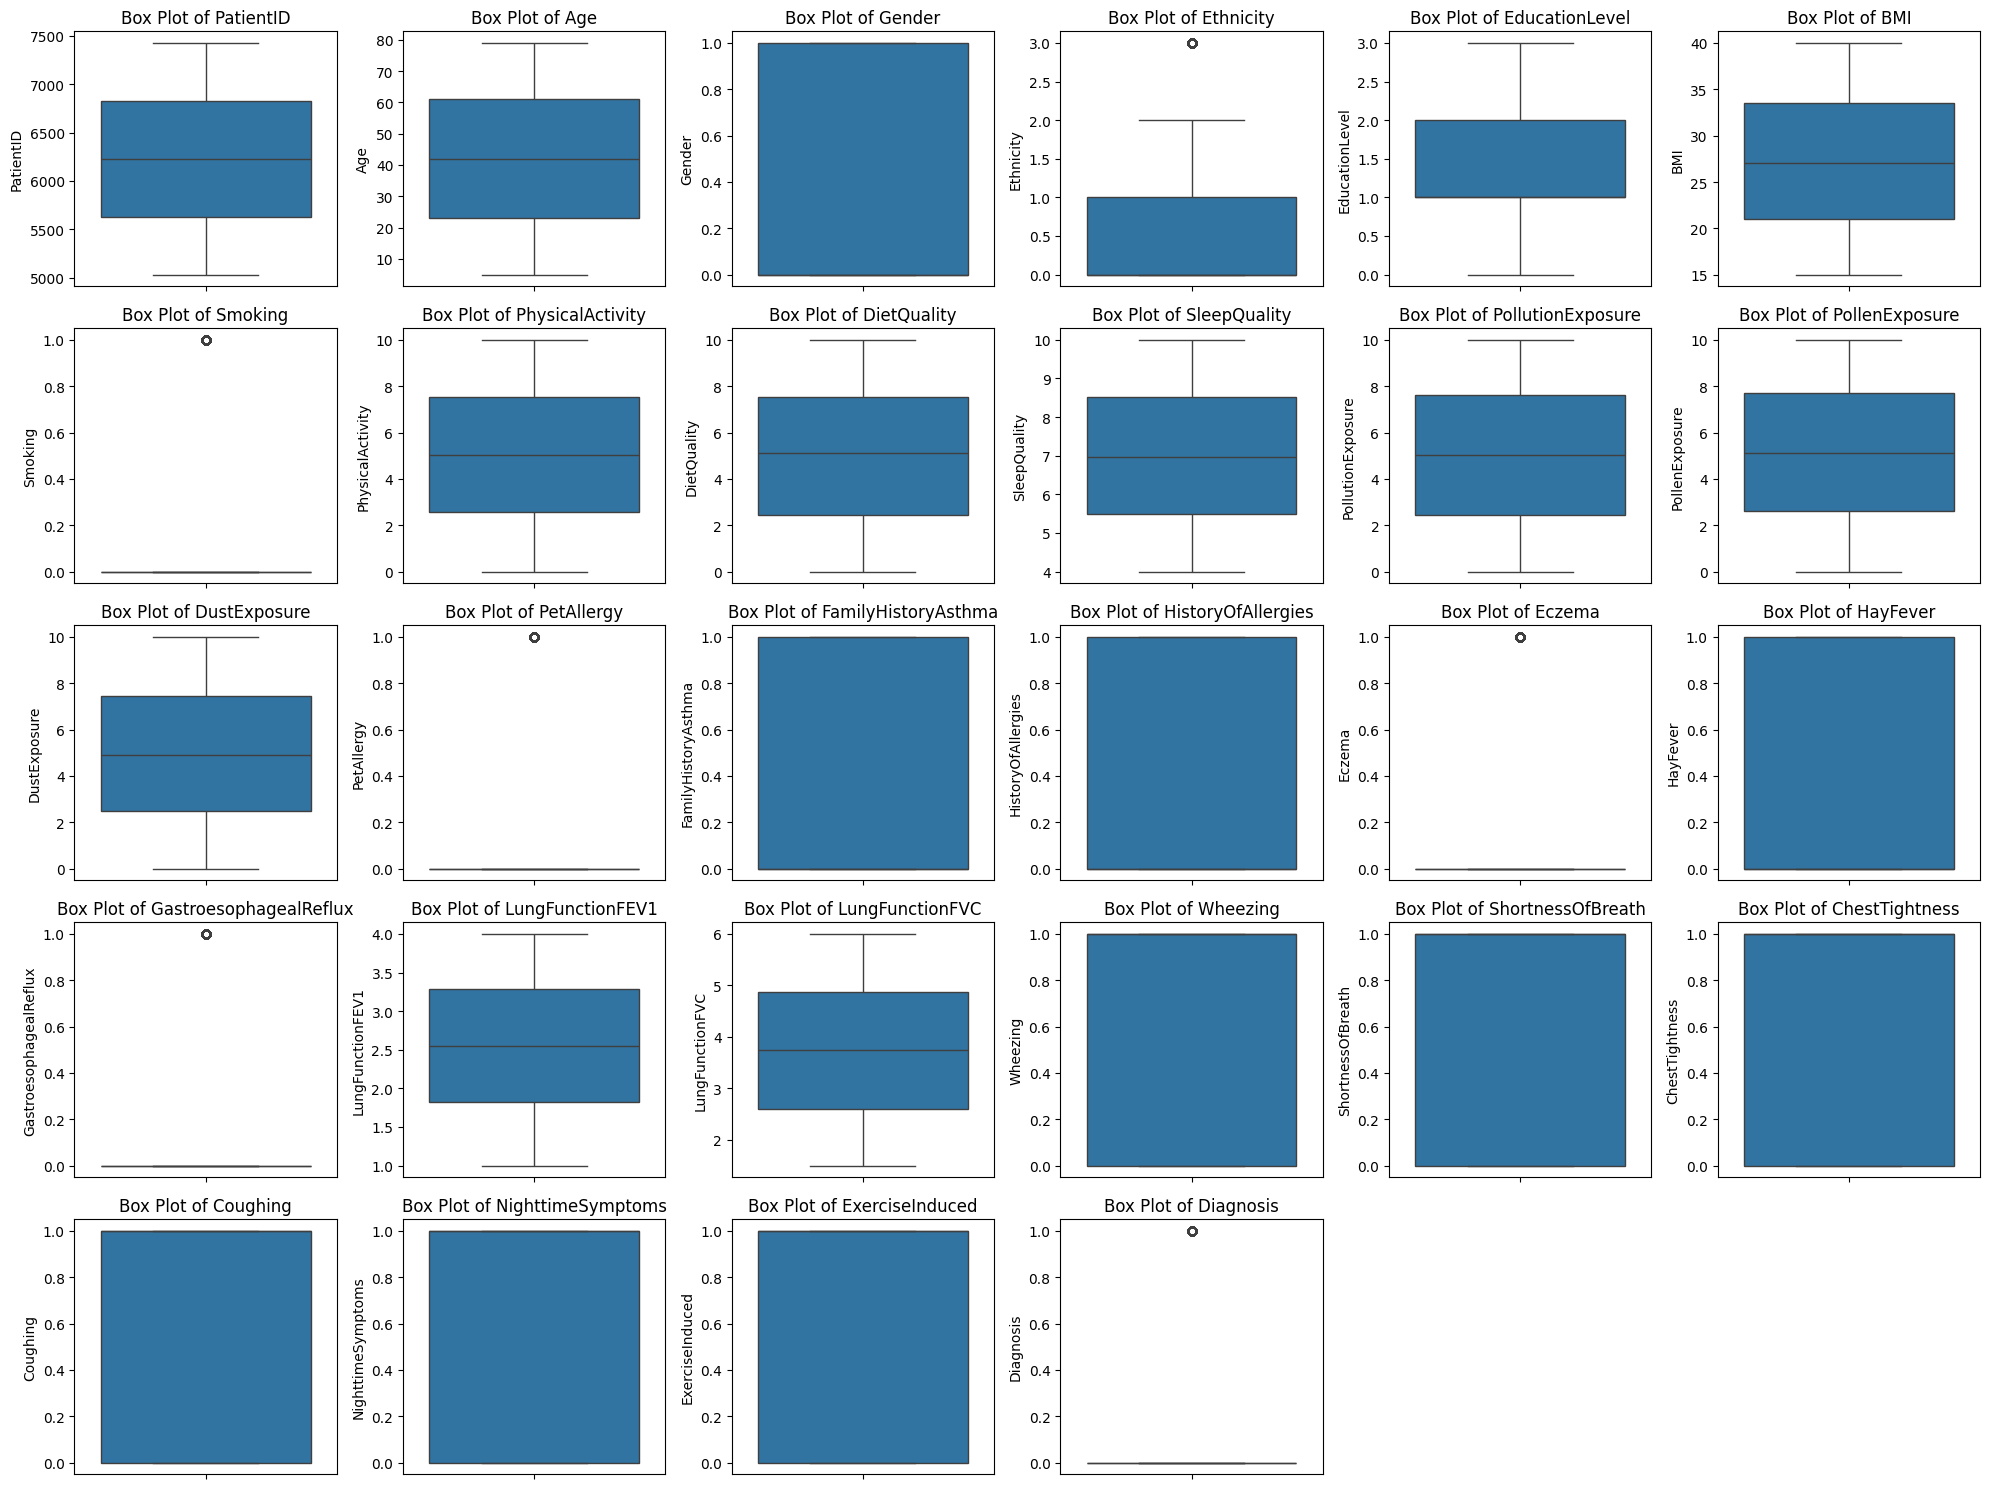

In [ ]:
# Combined Box Plots for Outliers Detection
plt.figure(figsize=(20, 15))
for i, feature in enumerate(numerical_features):
    plt.subplot(5, 6, i + 1)  # Adjust the grid size based on the number of features
    sns.boxplot(data[feature])
    plt.title(f'Box Plot of {feature}')
    plt.tight_layout()

plt.savefig('combined_boxplot.png')
plt.show()

In [ ]:
# Check class distribution
print(data['Diagnosis'].value_counts())

Diagnosis
0    2268
1     124
Name: count, dtype: int64


In [ ]:


# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_top_scaled, y)

# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

y_resampled.value_counts()

Diagnosis
0    2268
1    2268
Name: count, dtype: int64

In [ ]:
from google.colab import files
files.download('best_asthma_detection_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>